In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Density estimation

In [376]:
def dphi(x):
    f1=1/np.sqrt(2*np.pi*2)*np.exp(-(x-0)*(x-0)/2)
    f2=1/np.sqrt(2*np.pi*6)*np.exp(-(x-7)*(x-7)/6)
    f3=1/np.sqrt(2*np.pi*3)*np.exp(-(x-12)*(x-12)/3)
    return (f1+f2+f3)/3

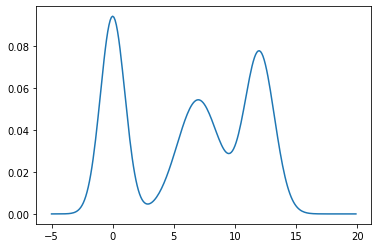

In [379]:
x=np.arange(-5,20,0.1)
y=dphi(x)
plt.plot(x,y)
plt.show()

In [380]:
data1=np.random.uniform(-5,27,5000)
data2=np.random.uniform(-5,17,5000)
p1=np.random.uniform(0,1,5000)
p2=np.random.uniform(0,1,5000)

In [381]:
prob=dphi(data1)
idx=p<=(prob/0.35)
sample1=data1[idx]

In [382]:
prob=dphi(data2)
idx=p<=(prob/0.35)
sample2=data2[idx]

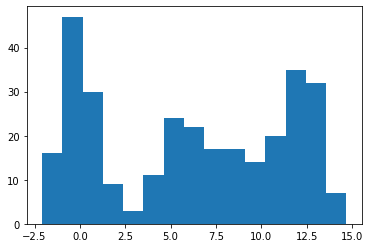

In [383]:
plt.hist(sample1,bins=15)
plt.show()

(-5.0, 17.0)

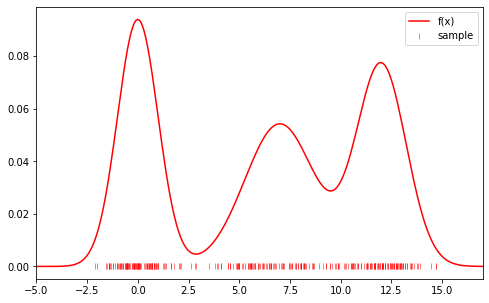

In [388]:
plt.figure(figsize=(8,5))
plt.scatter(sample1,np.zeros(sample1.shape[0]),marker='|',linewidths=0.5,color='red')
plt.plot(x,y,color='red')
plt.legend(['f(x)','sample'])
plt.xlim([-5,17])

In [541]:
class Kernel:
    def __init__(self,d):
        self.d=d
    
    def fit(self,xtrain):
        i,j=xtrain.shape
        self.dim=j #feature space
        self.xtrain=xtrain.T.reshape(1,j,i)
        self.n=xtrain.shape[0]
        
    def predict(self,x):
        i,j=x.shape
        z=x.reshape(i,j,1)
        mu=self.xtrain
        r=self.f(z-mu).sum(1)
        
        return r/self.n
    
    def le(self,x):
        r=self.predict(x)
        r=-np.log(r).sum()
        
        return r
    
    def f(self,x):
        xsq=(x*x).mean(1)
        p=1/np.sqrt(2*np.pi*self.d**2)*np.exp(-xsq/(self.d**2))
        
        return p

In [390]:
K=Kernel(1)
K.fit(sample1)

In [404]:
xs=np.arange(-5,17,0.1)
dists=[]
les=[]
ds=[0.1,0.3,0.5,1,2,10]
for d in ds:
    K.d=d
    dist=K.predict(xs)
    le=K.le(sample2)
    les.append(le)
    dists.append(dist)

In [405]:
les

[1704.7349234613143,
 1461.4655585614466,
 1445.827357263615,
 1445.3439168815596,
 1485.5110740432044,
 1709.6891878986276]

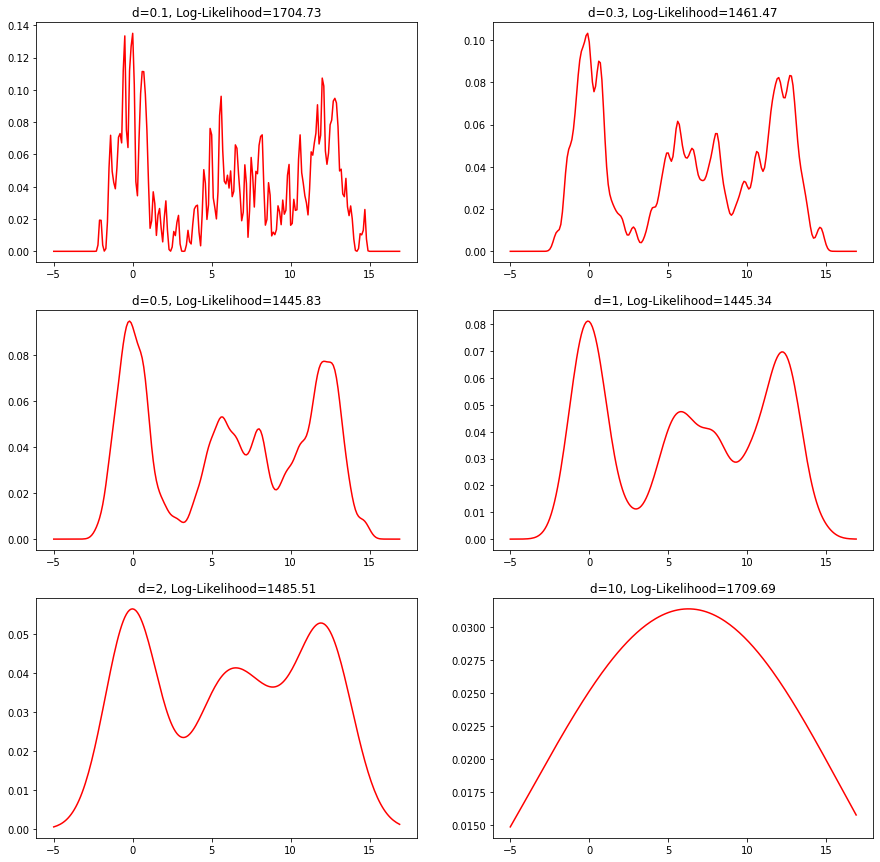

In [410]:
fig,axs=plt.subplots(3,2,figsize=(15,15))
for k,dist,d,le in zip(range(6),dists,ds,les):
    i=k//2
    j=k%2
    axs[i,j].plot(xs,dist,color='red')
    axs[i,j].set_title(f'd={d}, Log-Likelihood={np.round(le,2)}')

# Regression

In [322]:
def f(x):
    y=x*x*np.exp(-0.05*x)
    return y

xtrain=np.arange(0,200)
eps=np.random.normal(0,10,200)
y=f(x)
ytrain=y+eps

xtest=np.random.randint(0,200,50)
ytest=f(xtest)+np.random.normal(0,10,50)

In [350]:
class KernelRg:
    def __init__(self,d):
        self.d=d
        
    def fit(self,x,y):
        self.x=x
        self.y=y
        
    def predict(self,x):
        z=x.reshape(-1,1)
        mu=self.x.reshape(1,-1)
        r=self.f(z-mu)
        r_=r*(self.y.reshape(1,-1))
        r_=r_.sum(1)
        N=r.sum(1)
        return r_/N
    
    def prob(self,x):
        z=x.reshape(-1,1)
        mu=self.x.reshape(1,-1)
        r=self.f(z-mu)
        p=r.sum(1)
        
        return p
    
    def le(self,x):
        p=self.prob(x)
        L=-np.log(p).sum()
        
        return L
        
    def f(self,x):
        p=1/np.sqrt(2*np.pi*self.d**2)*np.exp(-(x)*(x)/(self.d**2))
        
        return p

In [259]:
z=np.arange(0,200,0.2)

In [359]:
K=KernelRg(0.1)
K.fit(xtrain,ytrain)

In [360]:
w=K.predict(z)

In [327]:
ypred=K.predict(xtest)

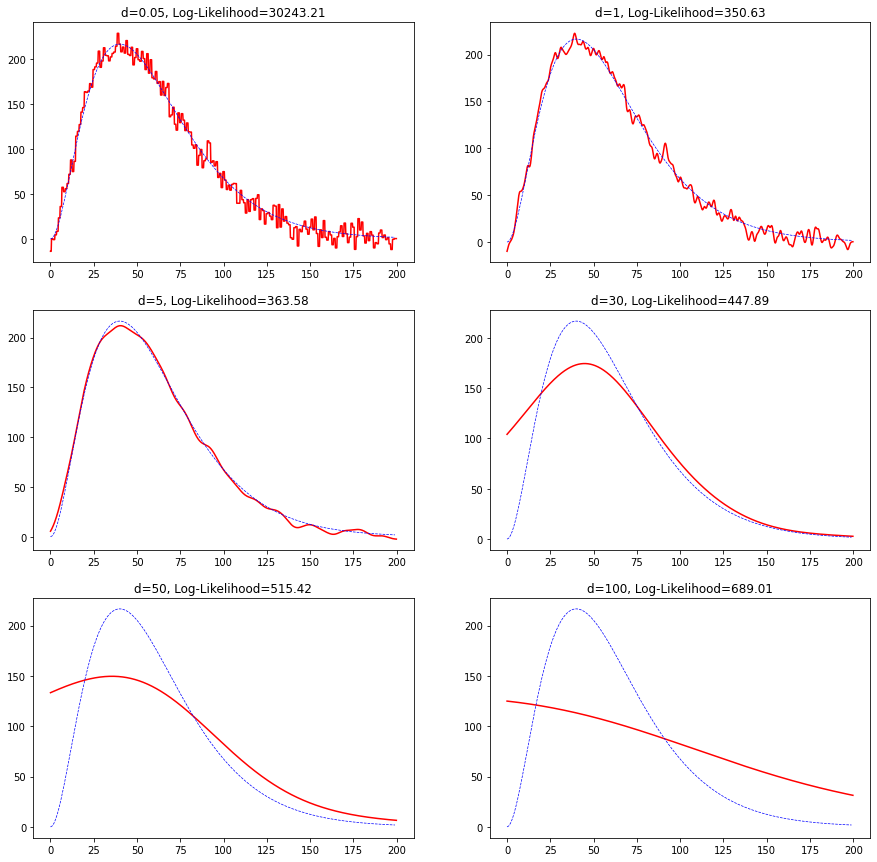

In [375]:
fig, axs =plt.subplots(3,2,figsize=(15,15))
for l,d in enumerate([0.05,1,5,30,50,100]):
    K.d=d
    w=K.predict(z)
    le=K.le(z)
    i=l//2
    j=l%2
    axs[i,j].plot(z,w,color='red')
    axs[i,j].plot(xtrain,y,color='blue',linestyle='--',linewidth=0.7)
    axs[i,j].set_title(f'd={d}, Log-Likelihood={np.round(le,2)}')

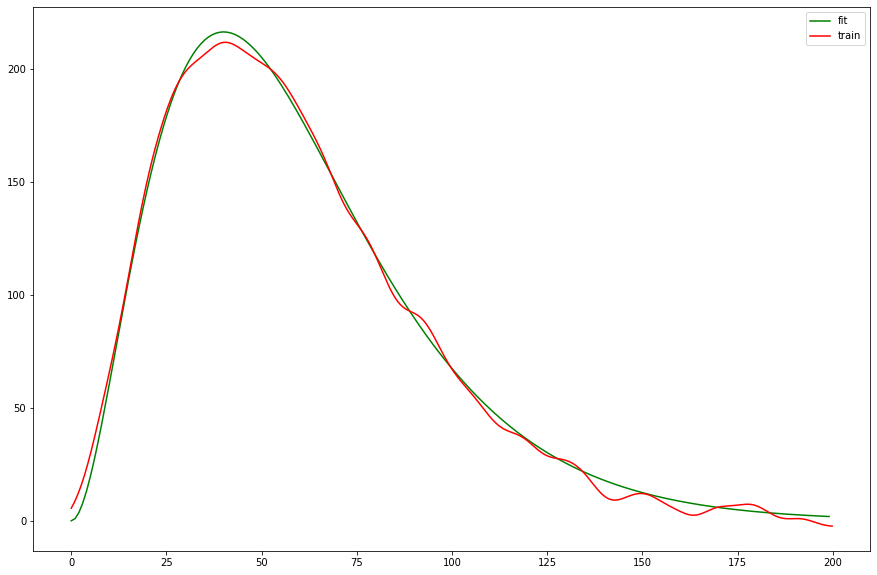

In [331]:
plt.figure(figsize=(15,10))
plt.plot(x,y,color='g')
#plt.scatter(xtrain,ytrain)
plt.plot(z,w,color='red')
plt.legend(['fit','train'])
plt.show()

# Classification

In [496]:
from sklearn.datasets import load_iris, load_breast_cancer

In [412]:
data=load_iris()

In [497]:
data=load_breast_cancer()

In [498]:
X=data['data']
Y=data['target']

In [499]:
X.shape

(569, 30)

In [482]:
from sklearn.model_selection import train_test_split

In [500]:
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2)

In [542]:
class KernelClf:
    def __init__(self,d):
        self.d=d
        
    def fit(self,x,y):
        labels, counts=np.unique(Y, return_counts=True)
        N=counts.sum()
        self.pc={l: c/N for l,c in zip(labels, counts)}
        
        self.kernels={}
        for l in labels:
            id_c= y==l
            x_c= x[id_c]
            K=Kernel(self.d)
            K.fit(x_c)
            self.kernels[l]=K
    
    def predict_prob(self,x):
        pv=[K.predict(x)*self.pc[c] for c,K in self.kernels.items()]
        P=sum(pv)
        prob=[p/P for p in pv]
        prob=np.concatenate([p.reshape(-1,1) for p in prob],axis=1)
        
        return prob
    
    def predict(self,x):
        pv=[K.predict(x)*self.pc[c] for c,K in self.kernels.items()]
        P=sum(pv)
        prob=[p/P for p in pv]
        prob=np.concatenate([p.reshape(-1,1) for p in prob],axis=1)
        
        return prob.argmax(1)

In [571]:
Kclf=KernelClf(d=8)

In [572]:
Kclf.fit(xtrain,ytrain)

In [573]:
ypred=Kclf.predict(xtest)

In [574]:
(ypred==ytest).mean()

0.956140350877193

In [579]:
error=[]
for d in range(1,25):
    Kclf.d=d
    Kclf.fit(xtrain,ytrain)
    ypred=Kclf.predict(xtest)
    err=(ypred!=ytest).mean()
    error.append((d,err))

/Users/JoaoGomes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [580]:
error

[(1, 0.05263157894736842),
 (2, 0.06140350877192982),
 (3, 0.05263157894736842),
 (4, 0.043859649122807015),
 (5, 0.043859649122807015),
 (6, 0.03508771929824561),
 (7, 0.03508771929824561),
 (8, 0.043859649122807015),
 (9, 0.043859649122807015),
 (10, 0.043859649122807015),
 (11, 0.05263157894736842),
 (12, 0.05263157894736842),
 (13, 0.05263157894736842),
 (14, 0.05263157894736842),
 (15, 0.05263157894736842),
 (16, 0.05263157894736842),
 (17, 0.05263157894736842),
 (18, 0.05263157894736842),
 (19, 0.05263157894736842),
 (20, 0.05263157894736842),
 (21, 0.05263157894736842),
 (22, 0.05263157894736842),
 (23, 0.05263157894736842),
 (24, 0.05263157894736842)]